In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from config.detector_config import detectors
import models.detector as de
from models.particle import Particle
import utils.fit_utils as fit_utils
import utils.data_io as data_io
import utils.evaluation as evaluation
from config.plot_config import *

Total price is within budget: 3730


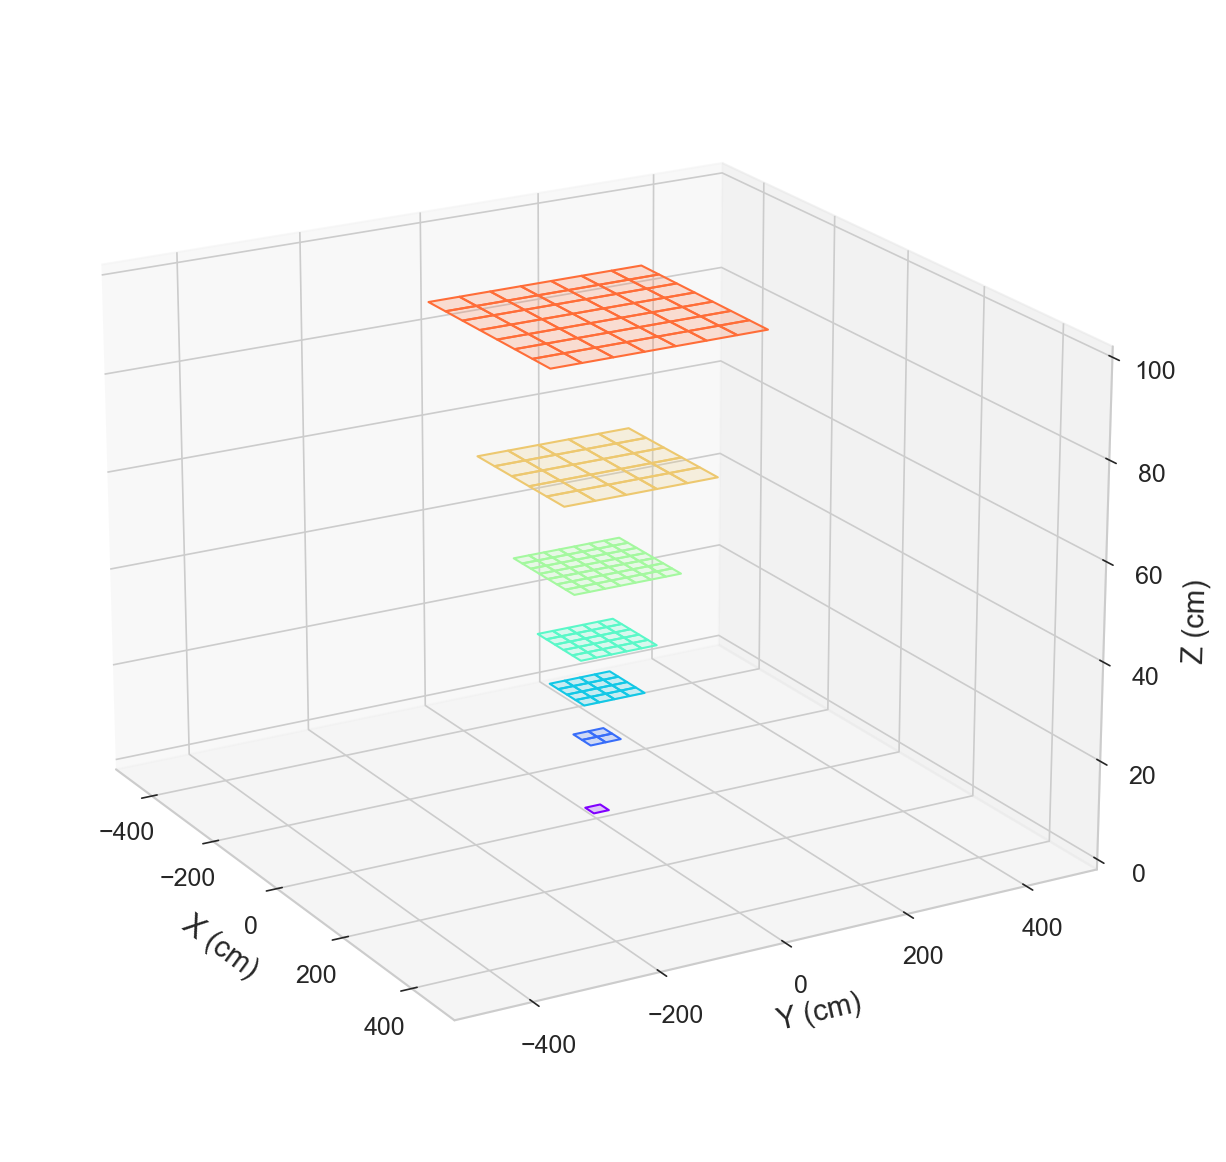

In [2]:
# Cost
de.Get_Price(detectors)

# Draw detectors
fig = plt.figure(1, figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
configure_plot(ax)

for d in detectors:
    d.clear()
    z = d.position[2]
    color = get_color_by_z(z)
    d.plot(ax, color=color)

plt.show()

In [3]:
# Particle Setting (Single Particle)
P1 = Particle()
print(P1)


# Particle hits detectors
hit_detectors = [d for d in detectors if d.is_hit(P1)]

print(f"Particle go throuth {len(hit_detectors)} Detector")
for d in hit_detectors:
    print(f"Center of Detector: {d.position}, lenth: {d.size}, time: {d.hit_time}")

Particle(position=[0. 0. 0.], direction=[-0.54461074  0.29892729  0.78360808]), speed=5.0
Particle go throuth 7 Detector
Center of Detector: (0, 0, 0), lenth: 25, time: 0.0
Center of Detector: (-12.5, 12.5, 15), lenth: 25, time: 3.828444463008128
Center of Detector: (-12.5, 12.5, 25), lenth: 25, time: 6.380740771680213
Center of Detector: (-25, 25, 35), lenth: 25, time: 8.933037080352298
Center of Detector: (-25, 25, 50), lenth: 25, time: 12.761481543360427
Center of Detector: (-50, 50, 70), lenth: 50, time: 17.866074160704596
Center of Detector: (-50, 50, 100), lenth: 50, time: 25.522963086720853


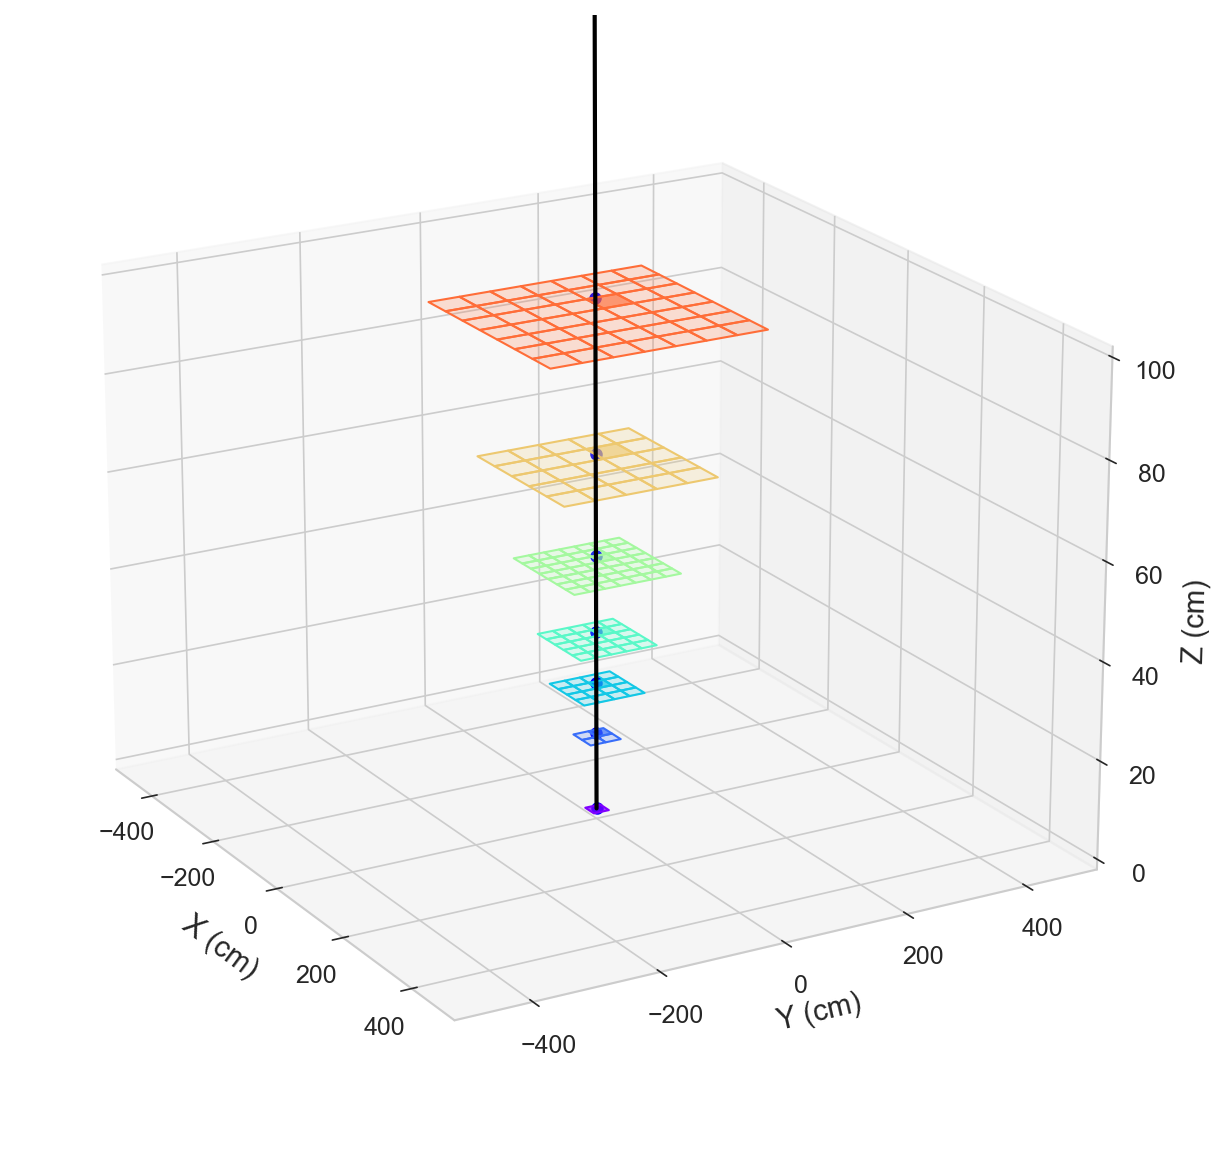

In [4]:
# Draw detectors and particle track
fig = plt.figure(1, figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
configure_plot(ax)

for d in detectors:
    z = d.position[2]
    color = get_color_by_z(z)
    if d in hit_detectors:
        pass
    else:
        d.plot(ax, color=color)

for d in hit_detectors:
    z = d.position[2]
    color = get_color_by_z(z)
    d.plot(ax, color=color)
    d.interaction_point(ax, P1)

Final_Point = P1.position_t(200)
# set high zorder value to make the track line drawn on top of all Detector Module
ax.plot([P1.position[0], Final_Point[0]], [P1.position[1],Final_Point[1]],[P1.position[2],Final_Point[2]], color="black", zorder=999)
plt.show()

In [5]:
# Save data
data_io.save_detected_data(detectors, P1)
data_io.save_truth_data(detectors, P1)

-----

Recorded data: (0.0, 0.0, 0.0) vs. Truth data (0.0, 0.0, 0.0)
Recorded data: (-12.5, 12.5, 15.0) vs. Truth data (-10.42505982409805, 5.722132716253319, 15.0)
Recorded data: (-12.5, 12.5, 25.0) vs. Truth data (-17.37509970683008, 9.536887860422198, 25.0)
Recorded data: (-25.0, 25.0, 35.0) vs. Truth data (-24.325139589562117, 13.351643004591075, 35.0)
Recorded data: (-25.0, 25.0, 50.0) vs. Truth data (-34.75019941366016, 19.073775720844395, 50.0)
Recorded data: (-50.0, 50.0, 70.0) vs. Truth data (-48.65027917912423, 26.703286009182158, 70.0)
Recorded data: (-50.0, 50.0, 100.0) vs. Truth data (-69.50039882732032, 38.14755144168879, 100.0)


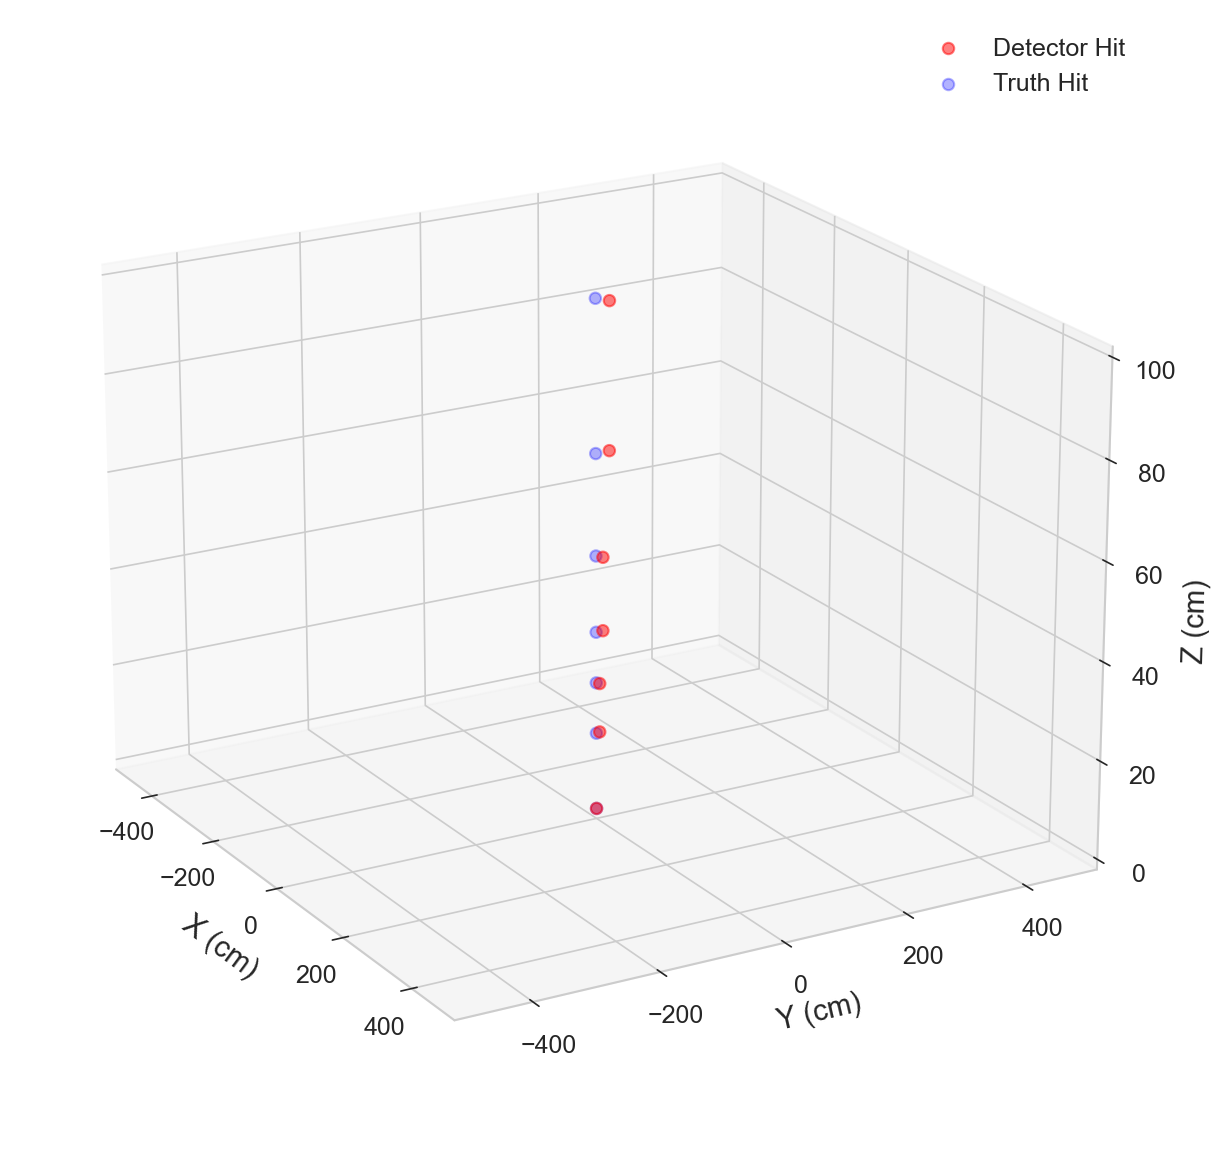

In [7]:
# Read detector data and scatter
recorded_data = pd.read_csv('data/detectors.csv')
truth_data = pd.read_csv('data/particle.csv')

recorded = recorded_data[['x', 'y', 'z']].values
truth = truth_data[['x', 'y', 'z']].values
rx, ry, rz = recorded.T
tx, ty, tz = truth.T

for i in range(len(rx)):
    print(f"Recorded data: ({rx[i]}, {ry[i]}, {rz[i]}) vs. Truth data ({tx[i]}, {ty[i]}, {tz[i]})")


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
configure_plot(ax)

ax.scatter(rx, ry, rz, c='r', s=30, label='Detector Hit', marker='o', alpha=0.5)
ax.scatter(tx, ty, tz, c='b', s=30, label='Truth Hit', marker='o', alpha=0.3)


plt.legend()
plt.show()

Direction: [-0.43476142  0.43476142  0.78864759]
Initial point: [-1.76771141  1.76771141  0.        ]
Angular Deviation: 0.17498925035645924
RMSE: 12.16


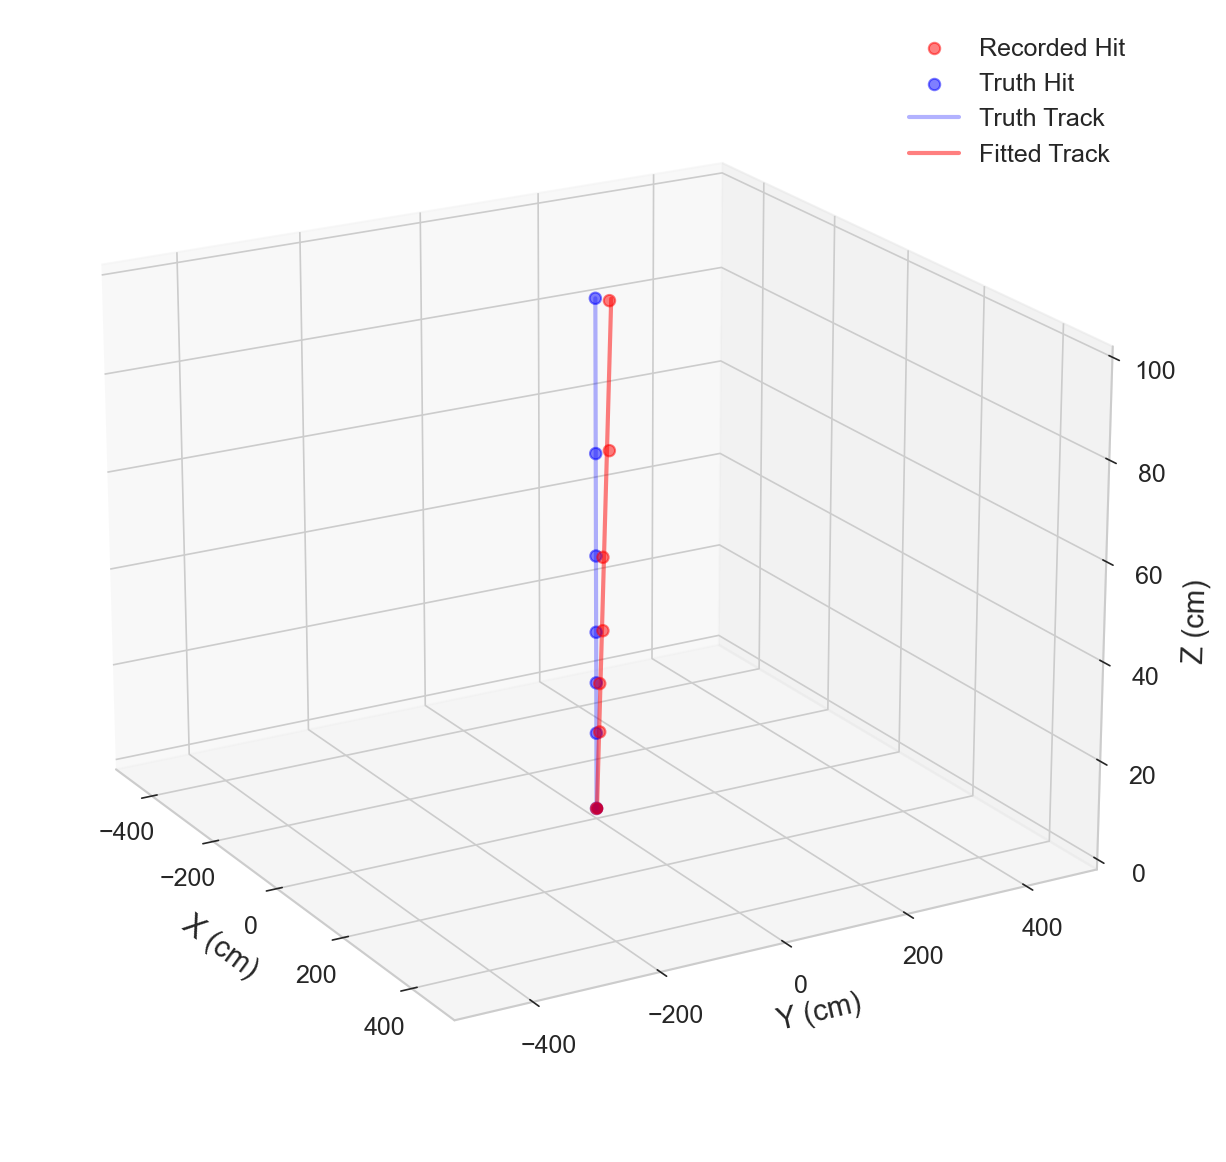

In [8]:
# Use PCA Fit
centroid, direction, init_point = fit_utils.PCA_Fit(recorded)

# Get direction and initial point
print(f"Direction: {direction}")
print(f"Initial point: {init_point}")

# Evaluate the Fit result: angular deviation and RMSE
evaluation.angular_deviation(P1.direction, direction)
evaluation.compute_rmse(truth, evaluation.get_points(detectors, centroid, direction))


# Draw
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
configure_plot(ax)

zs = [truth[:,2].min(), truth[:,2].max()]
ys = init_point[1] + (zs - init_point[2]) * direction[1] / direction[2]
xs = init_point[0] + (zs - init_point[2]) * direction[0] / direction[2]

ax.scatter(rx, ry, rz, c='r', s=30, label='Recorded Hit', marker='o', alpha=0.5)
ax.scatter(tx, ty, tz, c='b', s=30, label='Truth Hit', marker='o', alpha=0.5)
ax.scatter(init_point[0], init_point[1], init_point[2], c='r')
ax.plot(tx, ty, tz, c='b', label='Truth Track', alpha=0.3)
ax.plot(xs, ys, zs, c='r', label='Fitted Track', alpha=0.5)

ax.legend()
plt.show()

Direction: [-0.43214867  0.43214867  0.79151441]
Initial Point: [-1.9909688  1.9909688  0.       ]
Angular Deviation: 0.1747449159501181
RMSE: 12.15


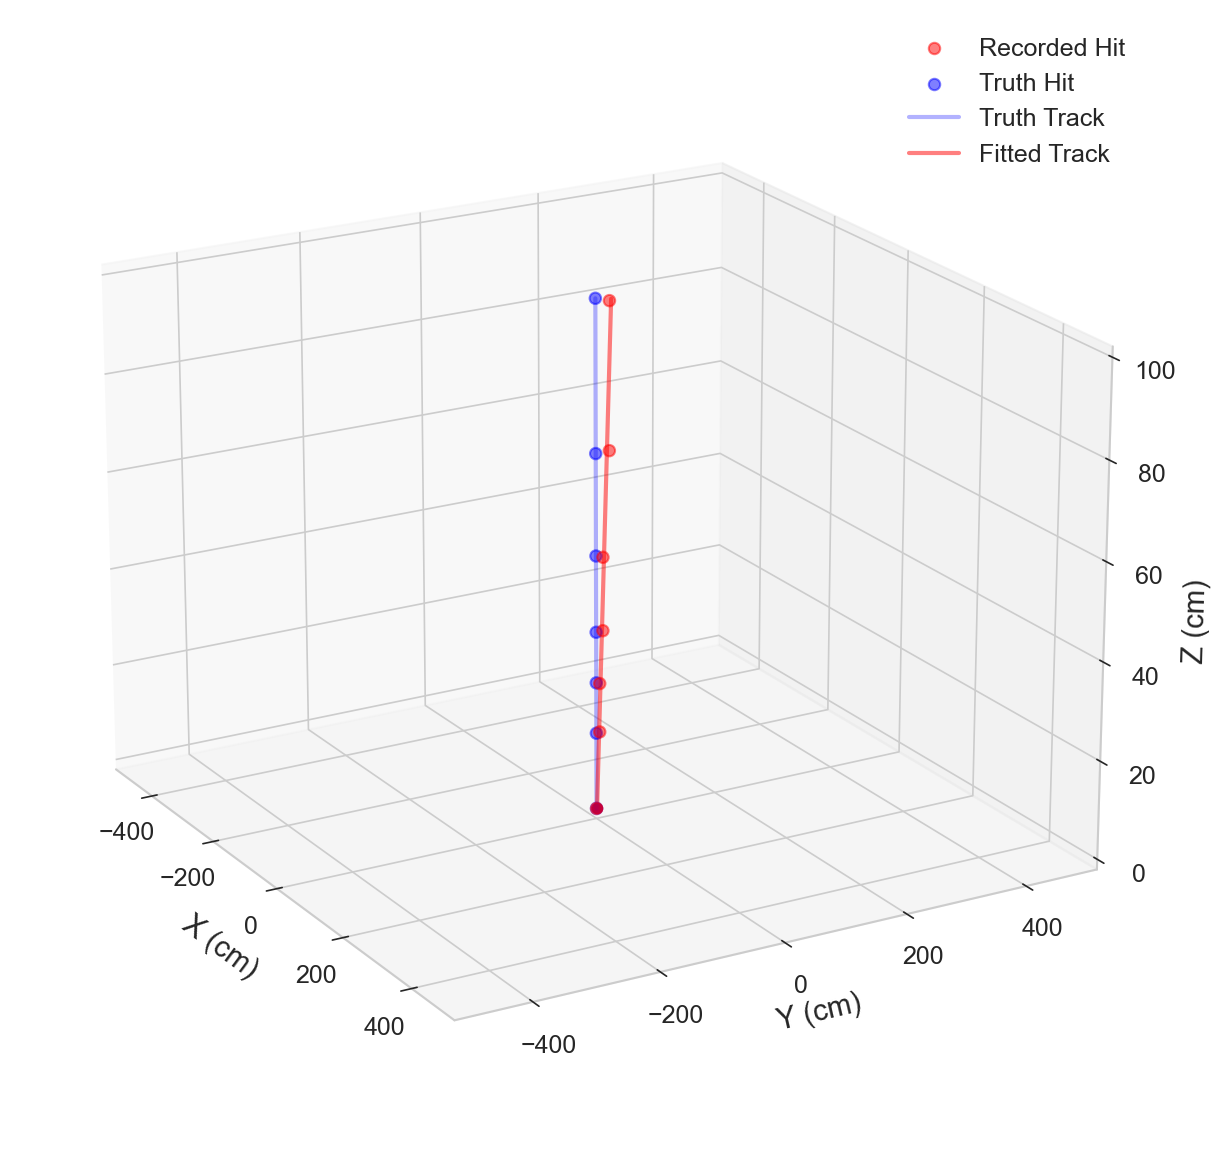

In [9]:
# Use Least Squares Fit
initial, direction, init_point = fit_utils.Linear_Fit(recorded)

# Get direction and initial point
print(f"Direction: {direction}")
print(f"Initial Point: {init_point}")

# Evaluate the Fit result: angular deviation and RMSE
evaluation.angular_deviation(P1.direction, direction)
evaluation.compute_rmse(truth, evaluation.get_points(detectors, initial, direction))


# Draw
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
configure_plot(ax)

zs = [truth[:,2].min(), truth[:,2].max()]
ys = init_point[1] + (zs - init_point[2]) * direction[1] / direction[2]
xs = init_point[0] + (zs - init_point[2]) * direction[0] / direction[2]

ax.scatter(rx, ry, rz, c='r', s=30, label='Recorded Hit', marker='o', alpha=0.5)
ax.scatter(tx, ty, tz, c='b', s=30, label='Truth Hit', marker='o', alpha=0.5)
ax.scatter(init_point[0], init_point[1], init_point[2], c='r')
ax.plot(tx, ty, tz, c='b', label='Truth Track', alpha=0.3)
ax.plot(xs, ys, zs, c='r', label='Fitted Track', alpha=0.5)

ax.legend()
plt.show()